In [2]:
import os
import astropy.units as u
from reduction_phangs_hst import contsub_qa, contsub_misc, contsub_postprocess
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
from astropy.io import fits
from astropy.table import Table
import astropy.wcs as wcs
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve, convolve_fft, interpolate_replace_nans
from astropy.stats import mad_std
import numpy as np
from radio_beam import Beam
from scipy.ndimage.morphology import binary_dilation, binary_closing
from reproject import reproject_interp
from matplotlib import pyplot as plt
from astropy.stats import SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from photutils.background import Background2D
from matplotlib import colors 
import glob
from astropy.wcs import WCS
import regions
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
# Define the galaxy
galaxy_dir = 'ngc628'
galaxy_cat = 'ngc0628'
galaxy = 'ngc628c'

# Define the filters
halpha_filter = 'f658n'
cont1_filter = 'f555w'
cont2_filter = 'f814w'

# Define the directories
inputdir_hst = '../hst/'
inputdir_muse = '../muse/'
inputdir_root = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/'

# Define input files for QA 
input_nebulae_mask_filename = '%s/data_misc/muse_catalouge/NGC0628_nebulae_mask_V2.fits' %inputdir_root
input_nebulae_catalog_filename = '%s/data_misc/muse_catalouge/Nebulae_catalogue_v2.fits' %inputdir_root

In [5]:
inputdir_hstcontsub = '%s/data/%s/hst_contsub' %(inputdir_root, galaxy_dir)
input_dir = '%s/%s_%s_%s/' % (inputdir_hstcontsub, halpha_filter, cont1_filter, cont2_filter) 
output_dir = '%s/%s_%s_%s_qa/' % (inputdir_hstcontsub, halpha_filter, cont1_filter, cont2_filter) 
contsub_misc.create_directory(output_dir)  

[INFO] Directory '/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data/ngc628/hst_contsub/f658n_f555w_f814w_qa/' already exists.


In [6]:
fits_dict = contsub_qa.read_fits_files(input_dir, input_nebulae_mask_filename, galaxy)
table_nebcat = contsub_qa.process_muse_catalouge(input_nebulae_catalog_filename, galaxy_cat)

Reprojecting nebulae mask...
Processing complete. Saving the processed nebulae mask as /Users/abarnes/Dropbox/work/Smallprojects/galaxies//data/ngc628/hst_contsub/f658n_f555w_f814w//ngc628c_nebmask_hst.fits
Reading nebulae catalog: /Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_misc/muse_catalouge/Nebulae_catalogue_v2.fits


In [7]:
flux_muse = contsub_qa.process_nebulae_flux(fits_dict['nebmask_muse'], fits_dict['musehalpha'], table_nebcat)
flux_hst = contsub_qa.process_nebulae_flux(fits_dict['nebmask_hst'], fits_dict['halpha'], table_nebcat)
flux_hst_bgsub = contsub_qa.process_nebulae_flux(fits_dict['nebmask_hst'], fits_dict['halpha_bgsub'], table_nebcat)
flux_hst_bgsub_an = contsub_qa.process_nebulae_flux(fits_dict['nebmask_hst'], fits_dict['halpha_bgsub_fit_anchored'], table_nebcat)
# flux_hst_bgsub_an_int = contsub_qa.process_nebulae_flux(fits_dict['nebmask_hst'], fits_dict['halpha_bgsub_fit_anchored_intnegs'], table_nebcat)
# flux_hst_bgsub_an_int_cos = contsub_qa.process_nebulae_flux(fits_dict['nebmask_hst'], fits_dict['halpha_bgsub_fit_anchored_intnegs_nocosmic'], table_nebcat)
# flux_hst_bgsub_an_int_cos_nnet = contsub_qa.process_nebulae_flux(fits_dict['nebmask_hst'], fits_dict['halpha_bgsub_fit_anchored_intnegs_nocosmic_nnet'], table_nebcat)

  0%|          | 0/2869 [00:00<?, ?it/s]

  0%|          | 0/2869 [00:00<?, ?it/s]

  0%|          | 0/2869 [00:00<?, ?it/s]

[INFO] xy-fit --- slope: 1.4523576089120192e-07, intercept: 0.41884908979326935


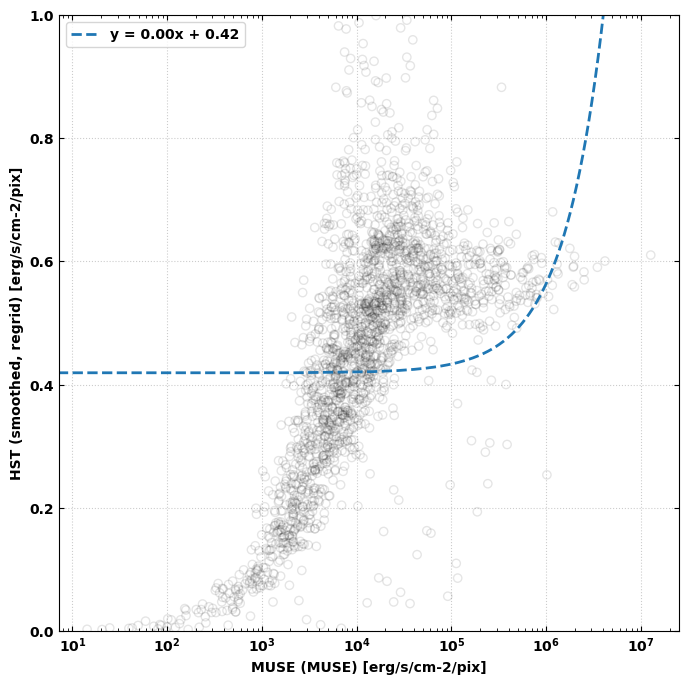

In [14]:
data1 = flux_hst_bgsub
data2 = flux_hst_bgsub/flux_muse

valid_indices = np.isfinite(data1) & np.isfinite(data2) & (data1!=0) & (data2!=0)
x_data = data1[valid_indices]
y_data = data2[valid_indices]

# Calculate a line of best fit for the data
slope, intercept = np.polyfit(x_data, y_data, 1)
# x_fit = np.linspace(np.min(x_data), np.max(x_data), 20)
x_fit = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 1000)
y_fit = slope * x_fit + intercept
print(f"[INFO] xy-fit --- slope: {slope}, intercept: {intercept}")

# Create a 2D histogram plot using the filtered data
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(x_data, y_data, ec='black', fc='none', alpha=0.1)
ax.plot(x_fit, y_fit, color='C0', linewidth=2, linestyle='--', label=f'y = {slope:.2f}x + {intercept:.2f}')

ax.set_xlabel('MUSE (MUSE) [erg/s/cm-2/pix]')
ax.set_ylabel('HST (smoothed, regrid) [erg/s/cm-2/pix]')
ax.legend()
ax.grid(True, ls=':', color='k', alpha=0.2)

# ax.set_xlim([-1e5, 1e5])
ax.set_ylim([0, 1])

ax.set_xscale('log')
# ax.set_yscale('log')

# plt.tight_layout()
# fig.savefig(rootdir+'fit.png', bbox_inches='tight')

# rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data/ngc628/hst_contsub/f658n_f555w_f814w/'
# output_filename = rootdir+'ngc628c_halpha_bgsub_fit_anchored_museregions.fits'
# hdu_input3 = fits.open(rootdir+'ngc628c_halpha_bgsub.fits')[0]
# hdu_fit_anchored = hdu_input3.copy()
# hdu_fit_anchored.data = (hdu_fit_anchored.data - (intercept)) / slope
# hdu_fit_anchored.writeto(output_filename, overwrite=True)

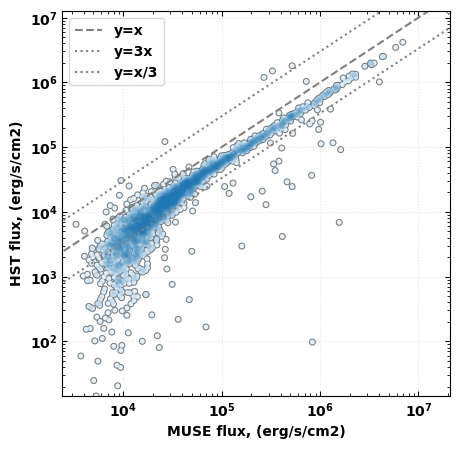

In [40]:
# contsub_qa.plot_flux_comparison(flux_muse, flux_hst, f'{output_dir}{galaxy}_catalogueflux_muse_hst.pdf')
contsub_qa.plot_flux_comparison(flux_muse, flux_hst_bgsub, f'{output_dir}{galaxy}_catalogueflux_muse_hst_bgsub.pdf')
# contsub_qa.plot_flux_comparison(flux_muse, flux_hst_bgsub_an, f'{output_dir}{galaxy}_catalogueflux_muse_hst_bgsub_an.pdf')
# contsub_qa.plot_flux_comparison(flux_muse, flux_hst_bgsub_an_int, f'{output_dir}{galaxy}_catalogueflux_muse_hst_bgsub_an_int.pdf')
# contsub_qa.plot_flux_comparison(flux_muse, flux_hst_bgsub_an_int_cos, f'{output_dir}{galaxy}_catalogueflux_muse_hst_bgsub_an_int_cos.pdf')
# contsub_qa.plot_flux_comparison(flux_muse, flux_hst_bgsub_an_int_cos_nnet, f'{output_dir}{galaxy}_catalogueflux_muse_hst_bgsub_an_int_cos_nnet.pdf')

In [1]:
contsub_qa.plot_flux_comparison(flux_muse, flux_hst_bgsub/flux_muse, f'{output_dir}{galaxy}_catalogueflux_muse_hst_bgsub.pdf')

NameError: name 'contsub_qa' is not defined

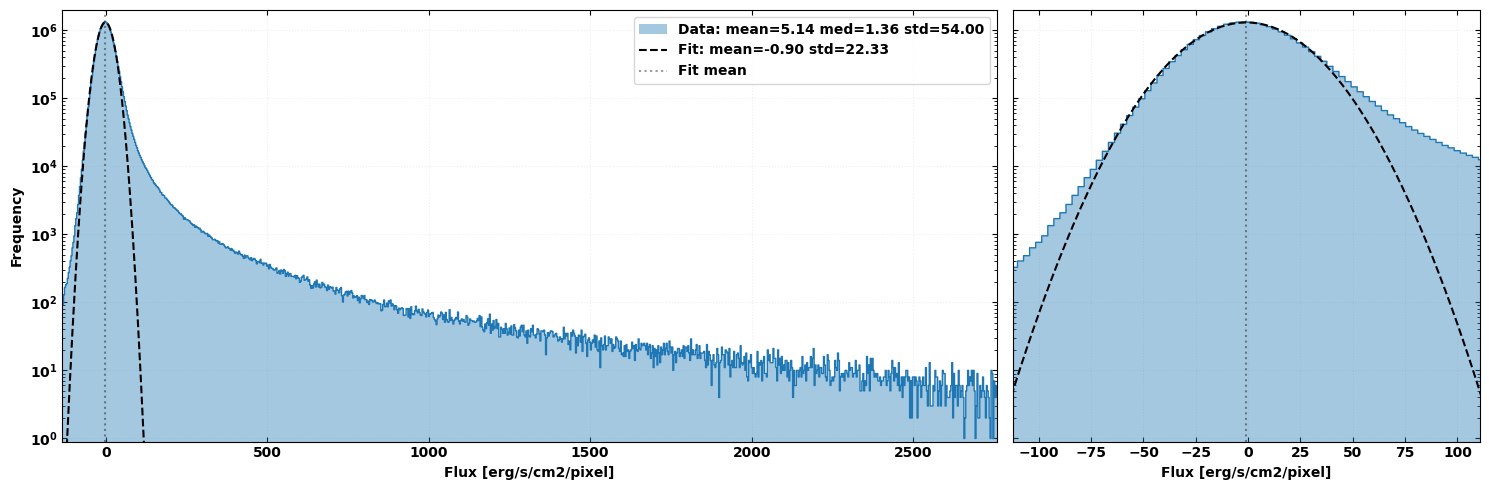

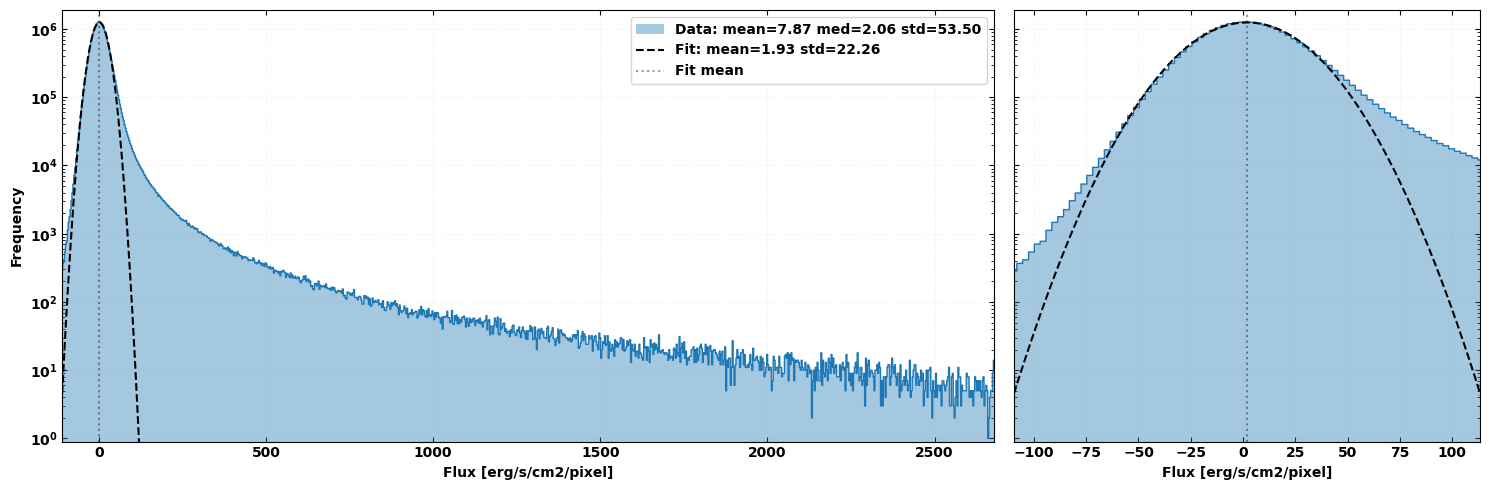

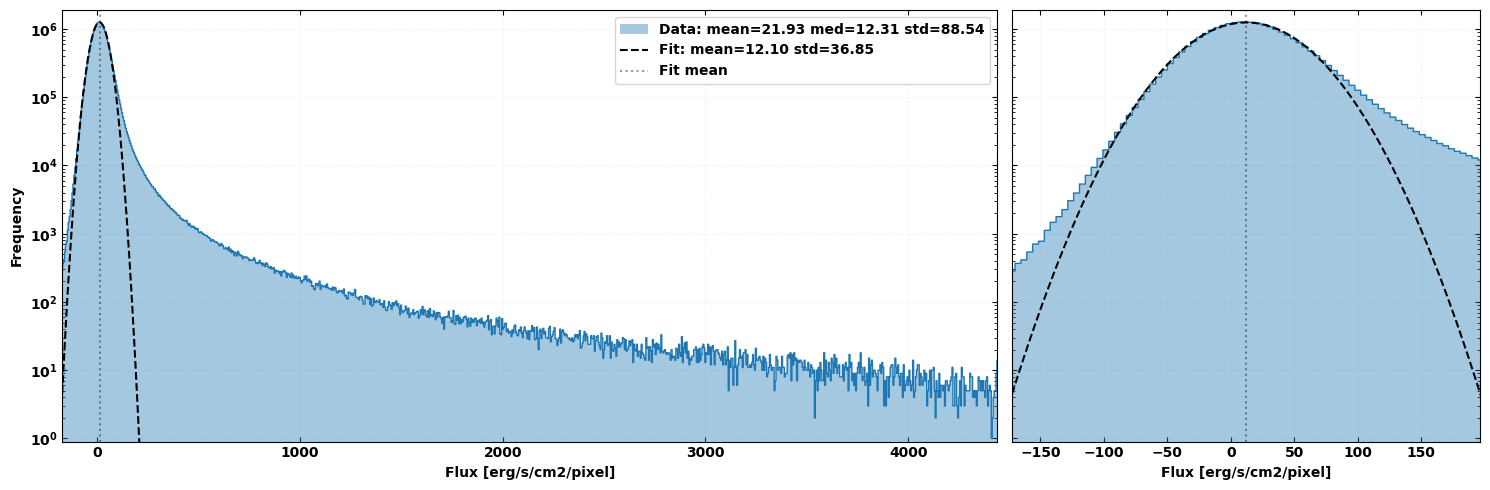

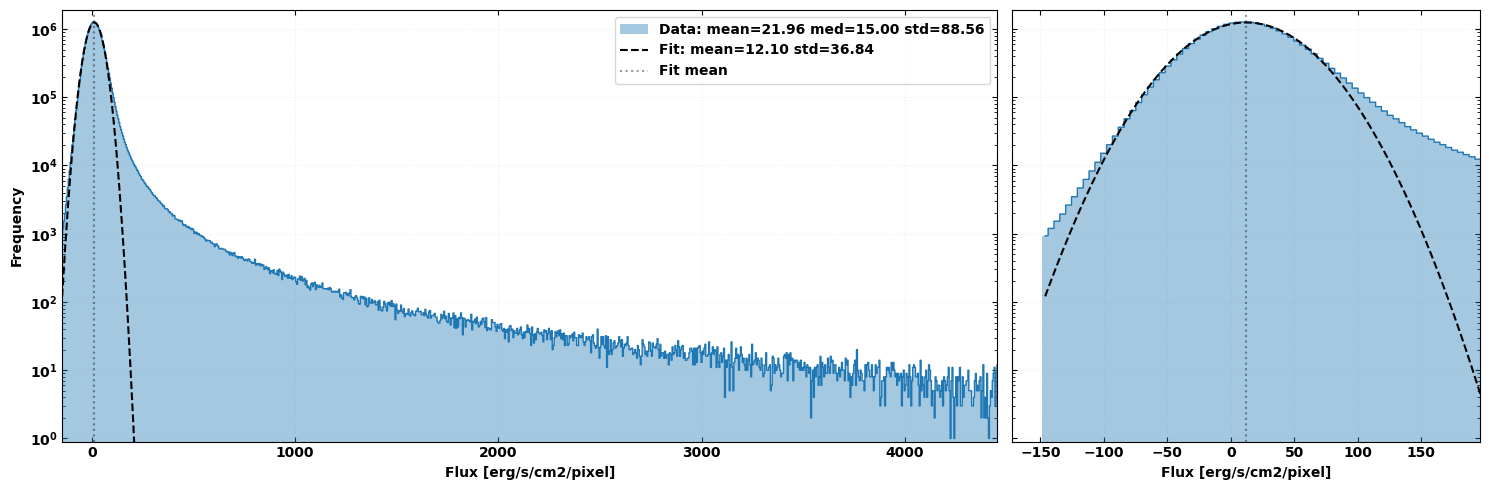

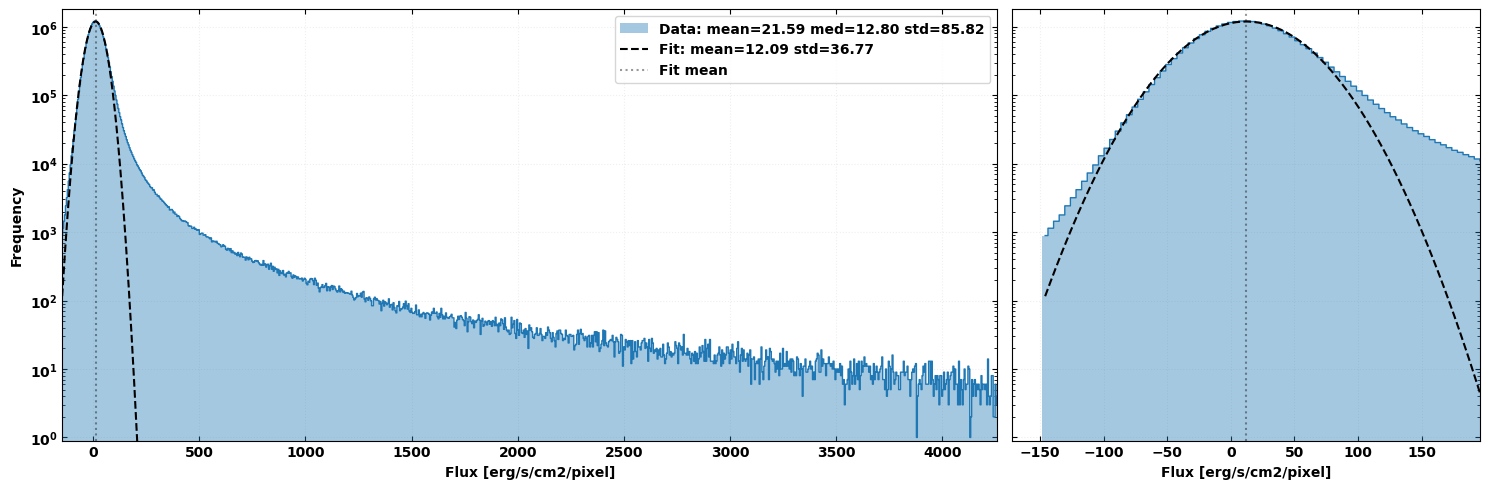

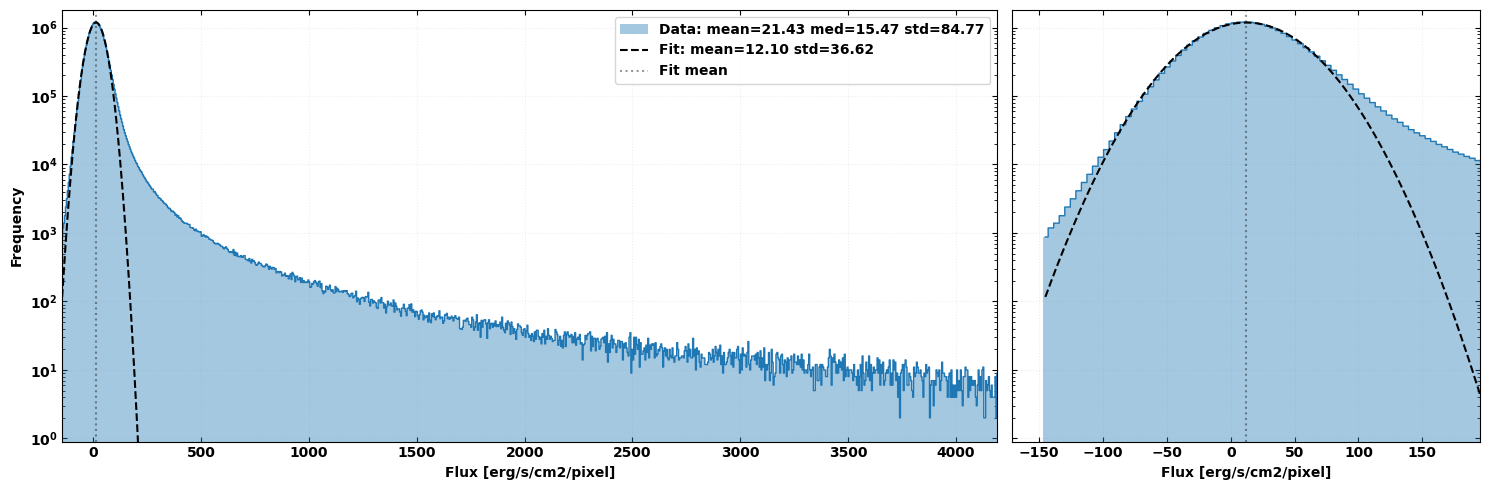

In [7]:
contsub_qa.run_histogram(fits_dict['halpha'], f'{output_dir}{galaxy}_hist_hst.pdf')
contsub_qa.run_histogram(fits_dict['halpha_bgsub'], f'{output_dir}{galaxy}_hist_hst_bgsub.pdf')
contsub_qa.run_histogram(fits_dict['halpha_bgsub_fit_anchored'], f'{output_dir}{galaxy}_hist_hst_bgsub_an.pdf')
contsub_qa.run_histogram(fits_dict['halpha_bgsub_fit_anchored_intnegs'], f'{output_dir}{galaxy}_hist_hst_bgsub_an_int.pdf')
contsub_qa.run_histogram(fits_dict['halpha_bgsub_fit_anchored_intnegs_nocosmic'], f'{output_dir}{galaxy}_hist_hst_bgsub_an_int_cos.pdf')
contsub_qa.run_histogram(fits_dict['halpha_bgsub_fit_anchored_intnegs_nocosmic_nnet'], f'{output_dir}{galaxy}_hist_hst_bgsub_an_int_cos_nnet.pdf')

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

()

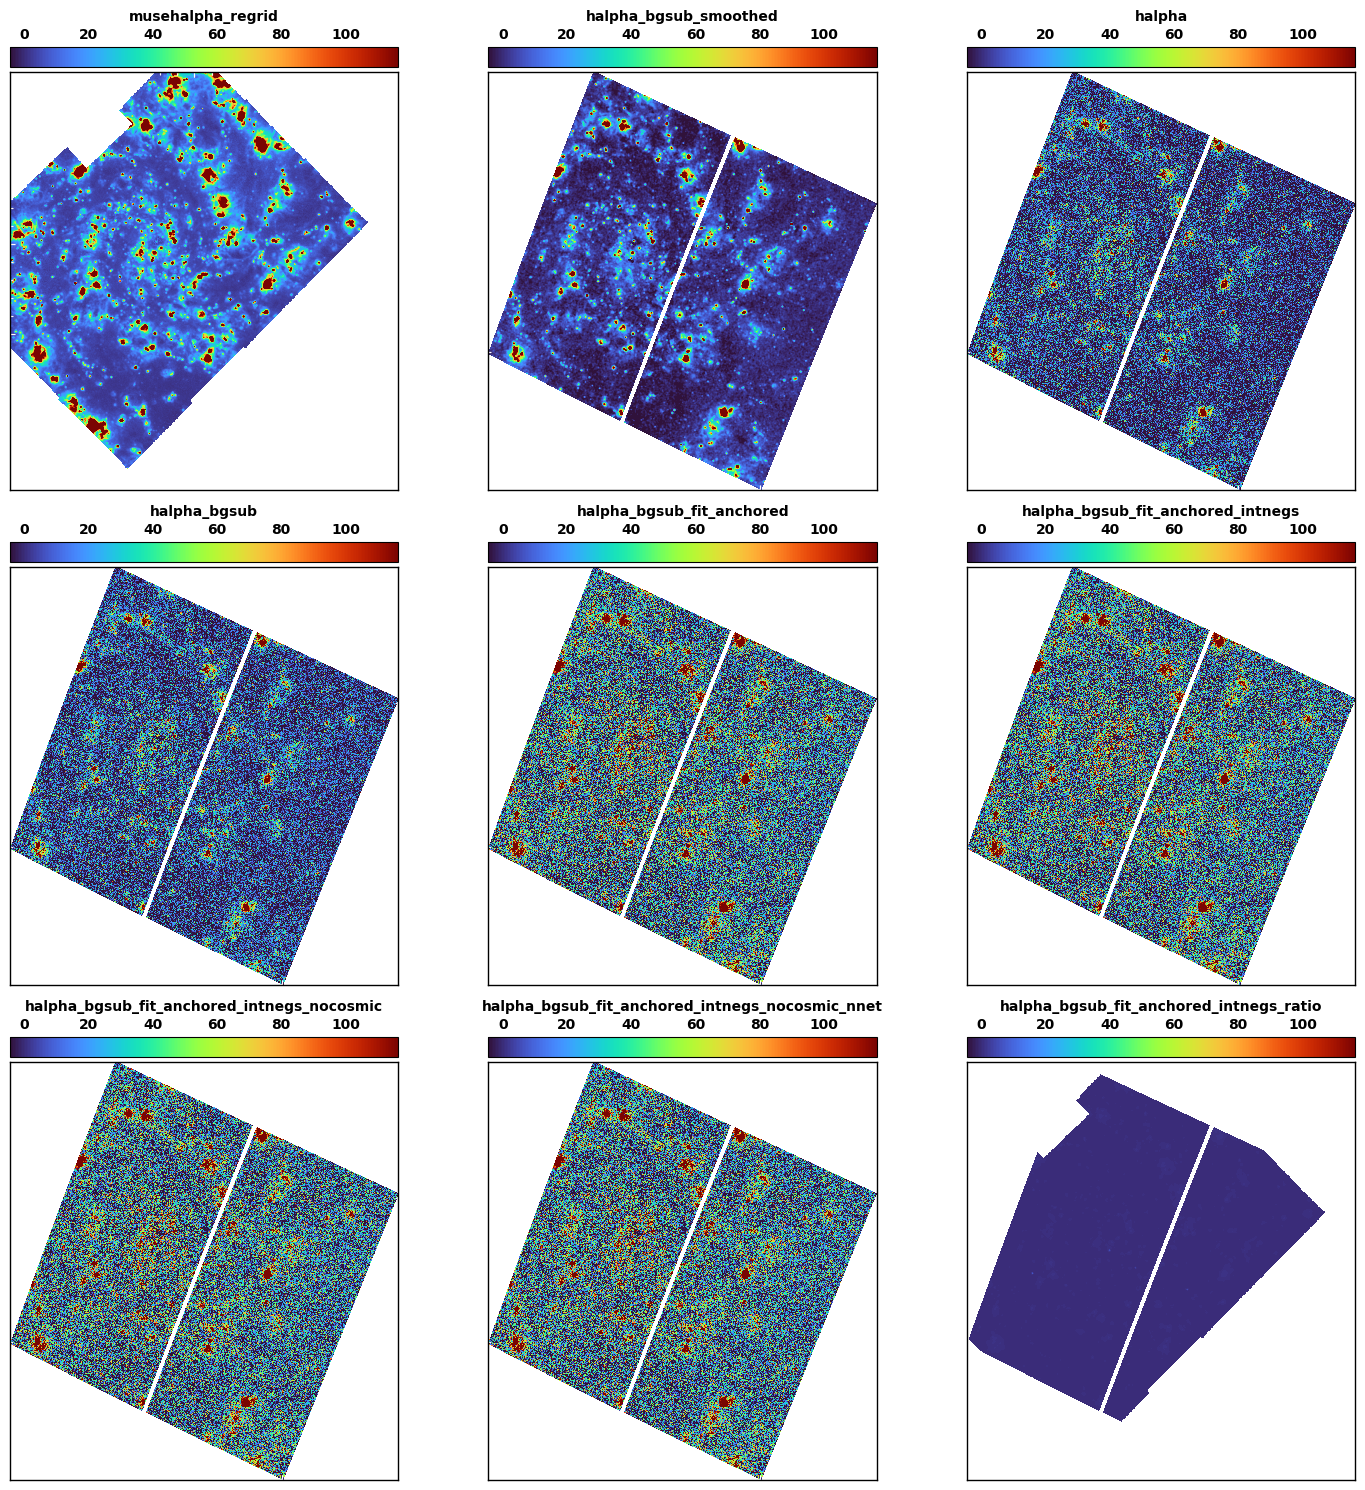

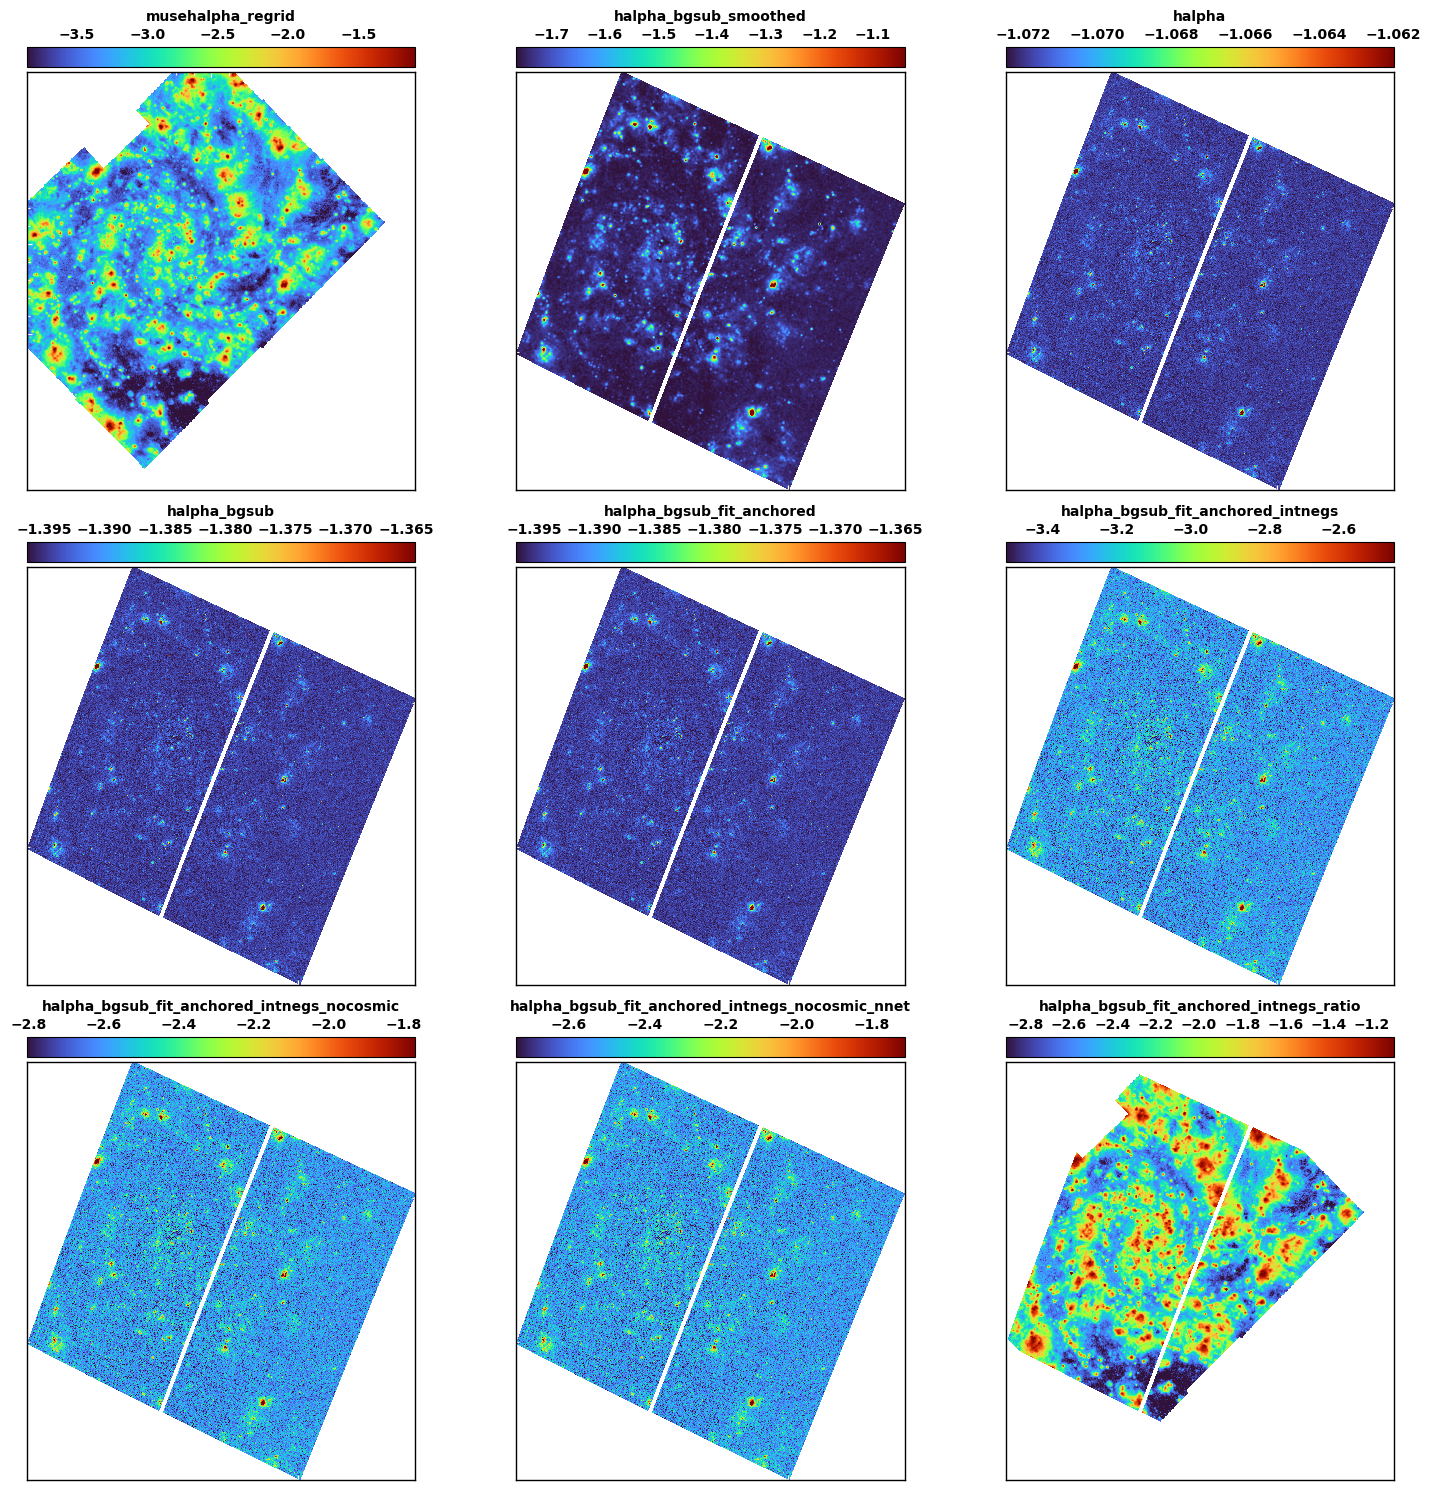

In [8]:
contsub_qa.plot_map(fits_dict, f'{output_dir}{galaxy}_maps.pdf')
contsub_qa.plot_map(fits_dict, f'{output_dir}{galaxy}_maps.pdf', norm=True)